In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import re

## I - Analyze the results

In [13]:
def load_message(expe):
  """
  Load messages stored during training procedure/
  Return numpy array with all the messages
  """
  np_load_old = np.load
  messages = np.load(expe,allow_pickle=True)
  np.load = np_load_old
  return messages

def img2gif(img_dir,output_file):
  """
  Transform a folder of images (img_dir) into a gif and save it with name output_file
  """
  # filepaths

  files = os.listdir(img_dir)
  files = [ _ for _ in files if ".png" in _ ]
  files = [int((_.split("test"))[1].split(".")[0]) for _ in files]
  files.sort()
  fp_in= [img_dir+"/test"+str(_)+".png" for _ in files]
  fp_out = output_file

  img, *imgs = [Image.open(f).resize((800,200)) for f in fp_in]
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=60, loop=0)

In [14]:
def clean_npy_files(base_dir="dir_save", analysis_dir="analysis"):
    """
    Deletes all .npy files from specified subdirectories in base_dir and the analysis directory.
    """
    subdirs = ["accuracy", "messages", "sender", "receiver"]

    # Clean .npy files from subdirectories under dir_save
    for subdir in subdirs:
        path = os.path.join(base_dir, subdir)
        npy_files = glob.glob(os.path.join(path, "*.npy"))
        for file in npy_files:
            try:
                os.remove(file)
                print(f"✅ Deleted: {file}")
            except Exception as e:
                print(f"⚠️ Error deleting {file}: {e}")

    # Clean .npy files from analysis directory
    analysis_files = glob.glob(os.path.join(analysis_dir, "*.npy"))
    for file in analysis_files:
        try:
            os.remove(file)
            print(f"✅ Deleted: {file}")
        except Exception as e:
            print(f"⚠️ Error deleting {file}: {e}")

In [25]:
# Variables for training


vocab_size = 20 # default : 40
max_length = 15 # default : 30
n_features = 25 # default : 100
n_epochs = 51 # default : 501
batch_size = 532 # default : 512
length_cost = 0.0  # default : 0.0
lr = 0.001 # default : 0.001
sender_hidden = 250 # default : 250
receiver_hidden = 600 # default : 600
receiver_embedding = 100 # default : 100
sender_embedding = 10 # default : 10
sender_entropy_coeff = 2.0 # default : 2.0
batches_per_epoch = 100 # default : 100
early_stopping_thr = 0.99   # default : 0.99
n_epochs = epoch = 50*((n_epochs-1)//50)
sender_weights = f"dir_save/sender/sender_weights_epoch_{epoch}_n_features_{n_features}.pth"
receiver_weights = f"dir_save/receiver/receiver_weights_epoch_{epoch}_n_features_{n_features}.pth"

**1. Length distribution for different epochs:** length distribution converges almost toward Optimal coding

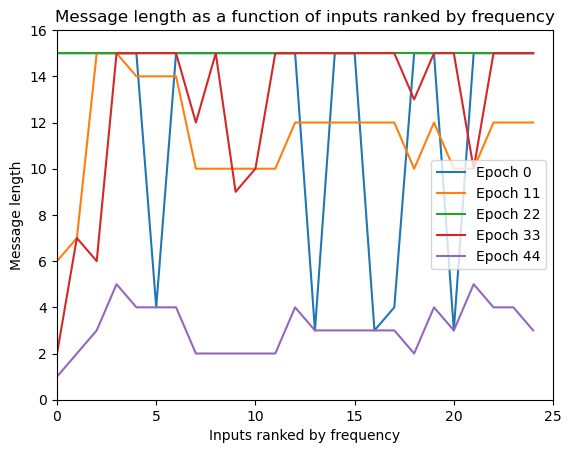

In [26]:
epochs = range(0, n_epochs, n_epochs//5+1)

for epoch in epochs:
  # Load messages
  messages=load_message("dir_save/messages/messages_epoch_"+str(epoch)+"_n_features_"+str(n_features)+".npy")

  # Construct the length distribution
  length_distribution=[]
  for message in messages:
    length_distribution.append(len(message))

  # Add epoch to plot
  plt.plot(length_distribution,label="Epoch "+str(epoch))

# Plot fig
plt.title("Message length as a function of inputs ranked by frequency")
plt.xlabel("Inputs ranked by frequency")
plt.ylabel("Message length")
plt.xlim((0,n_features))
plt.ylim((0,max_length+1))
plt.legend()
plt.show()

**2. Accuracy evolution**

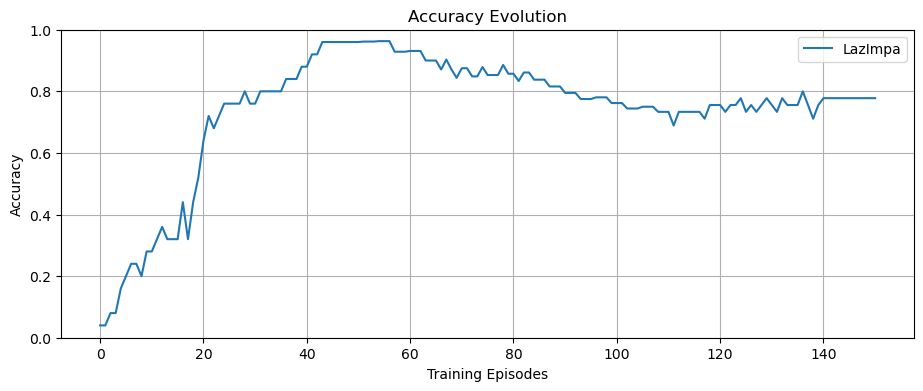

In [51]:
accuracy = []

# Find all matching accuracy files
files = glob.glob("dir_save/accuracy/accuracy_epoch_*_n_features_*.npy")

# Extract max epoch
epochs = []
for f in files:
    match = re.search(r'accuracy_epoch_(\d+)_n_features_', f)
    if match:
        epochs.append(int(match.group(1)))

max_epoch = max(epochs)

# Compute accuracy for each epoch (if file exists)
for i in range(max_epoch + 1):
    matching_files = [f for f in files if f"accuracy_epoch_{i}_" in f]
    if matching_files:
        data = [np.mean(np.load(f)) for f in matching_files]
        accuracy.append(np.mean(data))
    else:
        accuracy.append(np.nan)  # handle missing epochs

# Plot
plt.figure(figsize=(11, 4))
plt.plot(accuracy, label="LazImpa", color="tab:blue")
plt.title("Accuracy Evolution")
plt.xlabel("Training Episodes")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

**3. Mean length evolution**

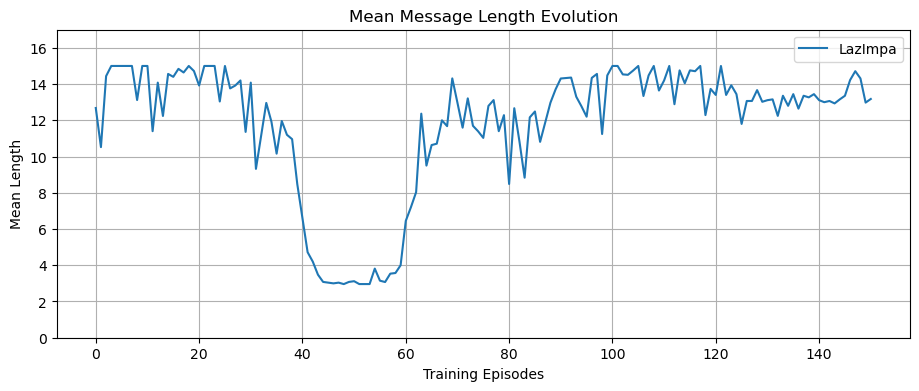

In [52]:
def load_message(file_path):
    return np.load(file_path, allow_pickle=True)

mean_length_evolution = []

# Get all message files
files = glob.glob("dir_save/messages/messages_epoch_*_n_features_*.npy")

# Extract available epoch numbers
epoch_nums = []
for f in files:
    match = re.search(r'messages_epoch_(\d+)_n_features_', f)
    if match:
        epoch_nums.append(int(match.group(1)))

max_epoch = max(epoch_nums)

# Compute mean length for each epoch
for epoch in range(max_epoch + 1):
    matching_files = [f for f in files if f"messages_epoch_{epoch}_" in f]
    if matching_files:
        lengths = []
        for f in matching_files:
            messages = load_message(f)
            lengths.extend([len(msg) for msg in messages])
        mean_length_evolution.append(np.mean(lengths))
    else:
        mean_length_evolution.append(np.nan)

# Plot
plt.figure(figsize=(11, 4))
plt.plot(mean_length_evolution, label="LazImpa", color="tab:blue")
plt.title("Mean Message Length Evolution")
plt.xlabel("Training Episodes")
plt.ylabel("Mean Length")
plt.ylim(0, np.nanmax(mean_length_evolution) + 2)
plt.grid(True)
plt.legend()
plt.show()

**4. Accuracy = f(mean_length)**: co-evolution of the accuracy and mean message length: allow us to spot the beginning of the regularization (laziness)

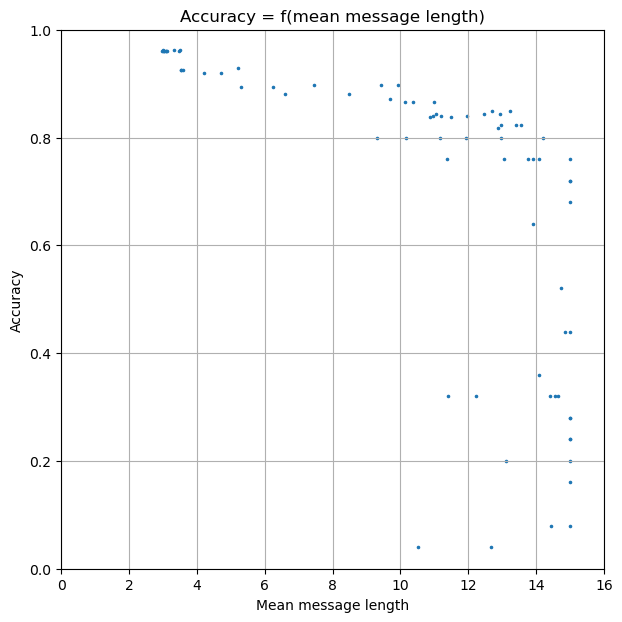

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

def load_message(file_path):
    return np.load(file_path, allow_pickle=True)

mean_length_evolution = []
accuracy = []

# Get all message and accuracy files
message_files = glob.glob("dir_save/messages/messages_epoch_*_n_features_*.npy")
accuracy_files = glob.glob("dir_save/accuracy/accuracy_epoch_*_n_features_*.npy")

# Extract common epochs
def extract_epoch(f, prefix):
    match = re.search(rf"{prefix}_epoch_(\d+)_n_features_", f)
    return int(match.group(1)) if match else None

message_epochs = {extract_epoch(f, "messages"): f for f in message_files}
accuracy_epochs = {extract_epoch(f, "accuracy"): f for f in accuracy_files}

common_epochs = sorted(set(message_epochs.keys()) & set(accuracy_epochs.keys()))

# Compute stats for each common epoch
for epoch in common_epochs:
    messages = load_message(message_epochs[epoch])
    lengths = [len(msg) for msg in messages]
    mean_length_evolution.append(np.mean(lengths))

    acc = np.mean(np.load(accuracy_epochs[epoch]))
    accuracy.append(acc)

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(mean_length_evolution, accuracy, s=2.5)
plt.title("Accuracy = f(mean message length)")
plt.xlabel("Mean message length")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(0, max(mean_length_evolution) + 1)
plt.grid(True)
plt.show()


**5. Position of informative symbols**: allows us to see where informative symbols are set within the messages

legend:
- yellow: uninformative ; 1: informative; purple: no symbol
- 1: uninformative ; 0: informative ; -1 no symbol

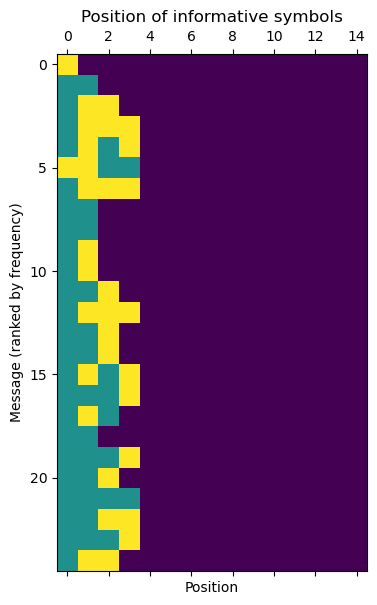

In [53]:
# Color the matrix of "information test"
plt.matshow(np.load("analysis/position_sieve.npy"))
plt.xlabel("Position")
plt.ylabel("Message (ranked by frequency)")
plt.title("Position of informative symbols")
plt.show()

🔍 Encoding evolution for message 0:
Epoch 0: [np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(4), np.int64(9), np.int64(4), np.int64(13), np.int64(9), np.int64(9), np.int64(16), np.int64(9)]
Epoch 1: [np.int64(0)]
Epoch 2: [np.int64(0)]
Epoch 3: [13, 13, 13, 18, 5, 18, 7, 7, 7, 7, 7, 7, 5, 14, 7]
Epoch 4: [4, 18, 14, 14, 14, 14, 14, 14, 7, 14, 14, 7, 7, 14, 14]
Epoch 5: [13, 11, 6, 11, 11, 11, 11, 8, 8, 8, 8, 8, 8, 9, 12]
Epoch 6: [14, 17, 6, 6, 6, 11, 11, 11, 11, 6, 4, 6, 15, 11, 11]
Epoch 7: [8, 5, 14, 14, 14, 6, 14, 14, 14, 11, 11, 14, 14, 14, 14]
Epoch 8: [np.int64(5), np.int64(5), np.int64(4), np.int64(0)]
Epoch 9: [5, 10, 8, 8, 8, 6, 9, 6, 9, 2, 8, 8, 6, 9, 2]
Epoch 10: [14, 10, 7, 7, 9, 7, 9, 7, 9, 7, 9, 7, 9, 7, 9]
Epoch 11: [np.int64(4), np.int64(7), np.int64(7), np.int64(4), np.int64(4), np.int64(0)]
Epoch 12: [np.int64(16), np.int64(10), np.int64(12), np.int64(14), np.int64(14), np.int64(11), np.int64(0)]
Epoch 13: [

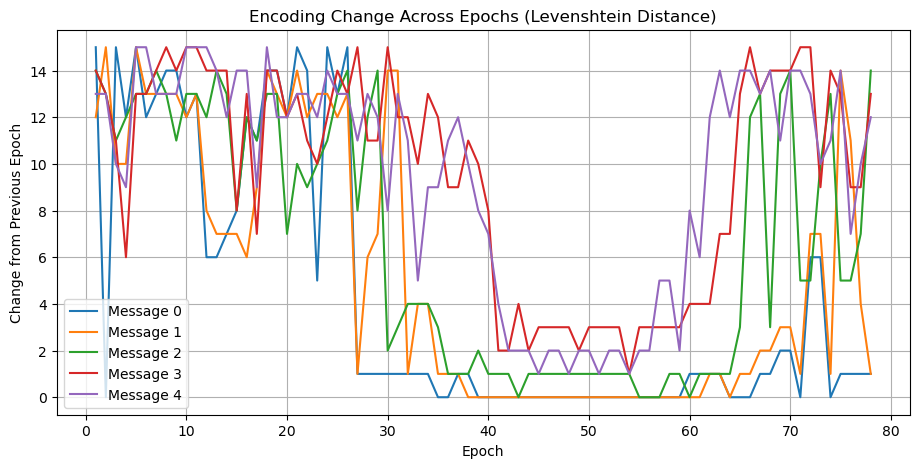

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

def load_message(file_path):
    return np.load(file_path, allow_pickle=True)

# Step 1: Get all message files, sorted by epoch
message_files = glob.glob("dir_save/messages/messages_epoch_*_n_features_*.npy")

def extract_epoch(f):
    match = re.search(r'messages_epoch_(\d+)_n_features_', f)
    return int(match.group(1)) if match else -1

# Sort files by epoch number
message_files = sorted(message_files, key=extract_epoch)
epochs = [extract_epoch(f) for f in message_files]

# Step 2: Track encoding of first 5 messages
tracked_messages = {i: [] for i in range(5)}  # message_id -> list of encodings

for f in message_files:
    messages = load_message(f)
    for i in range(5):
        if i < len(messages):
            tracked_messages[i].append(list(messages[i]))  # Ensure it's a list (for easy comparison)
        else:
            tracked_messages[i].append([])  # Missing message

# Step 3: Print encoding evolution of the first message
print("🔍 Encoding evolution for message 0:")
for epoch, enc in zip(epochs, tracked_messages[0]):
    print(f"Epoch {epoch}: {enc}")

# Step 4: Define a metric to measure evolution
# Let's use Levenshtein distance to measure change between successive encodings

def levenshtein(a, b):
    """Compute Levenshtein distance between two lists."""
    dp = np.zeros((len(a)+1, len(b)+1), dtype=int)
    for i in range(len(a)+1):
        dp[i][0] = i
    for j in range(len(b)+1):
        dp[0][j] = j
    for i in range(1, len(a)+1):
        for j in range(1, len(b)+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,     # deletion
                           dp[i][j-1] + 1,     # insertion
                           dp[i-1][j-1] + cost)  # substitution
    return dp[-1][-1]

# Step 5: Compute evolution score (distance between successive epochs)
evolution_scores = {i: [] for i in range(5)}

for i in range(5):
    messages = tracked_messages[i]
    for t in range(1, len(messages)):
        prev = messages[t-1]
        curr = messages[t]
        dist = levenshtein(prev, curr)
        evolution_scores[i].append(dist)

# Step 6: Plot evolution over epochs
plt.figure(figsize=(11, 5))
for i in range(5):
    plt.plot(epochs[1:], evolution_scores[i], label=f"Message {i}")
plt.title("Encoding Change Across Epochs (Levenshtein Distance)")
plt.xlabel("Epoch")
plt.ylabel("Change from Previous Epoch")
plt.legend()
plt.grid(True)
plt.show()


🔍 Encoding evolution for message 0:
Epoch 0: [np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(18), np.int64(4), np.int64(9), np.int64(4), np.int64(13), np.int64(9), np.int64(9), np.int64(16), np.int64(9)]
Epoch 1: [np.int64(0)]
Epoch 2: [np.int64(0)]
Epoch 3: [13, 13, 13, 18, 5, 18, 7, 7, 7, 7, 7, 7, 5, 14, 7]
Epoch 4: [4, 18, 14, 14, 14, 14, 14, 14, 7, 14, 14, 7, 7, 14, 14]
Epoch 5: [13, 11, 6, 11, 11, 11, 11, 8, 8, 8, 8, 8, 8, 9, 12]
Epoch 6: [14, 17, 6, 6, 6, 11, 11, 11, 11, 6, 4, 6, 15, 11, 11]
Epoch 7: [8, 5, 14, 14, 14, 6, 14, 14, 14, 11, 11, 14, 14, 14, 14]
Epoch 8: [np.int64(5), np.int64(5), np.int64(4), np.int64(0)]
Epoch 9: [5, 10, 8, 8, 8, 6, 9, 6, 9, 2, 8, 8, 6, 9, 2]
Epoch 10: [14, 10, 7, 7, 9, 7, 9, 7, 9, 7, 9, 7, 9, 7, 9]
Epoch 11: [np.int64(4), np.int64(7), np.int64(7), np.int64(4), np.int64(4), np.int64(0)]
Epoch 12: [np.int64(16), np.int64(10), np.int64(12), np.int64(14), np.int64(14), np.int64(11), np.int64(0)]
Epoch 13: [

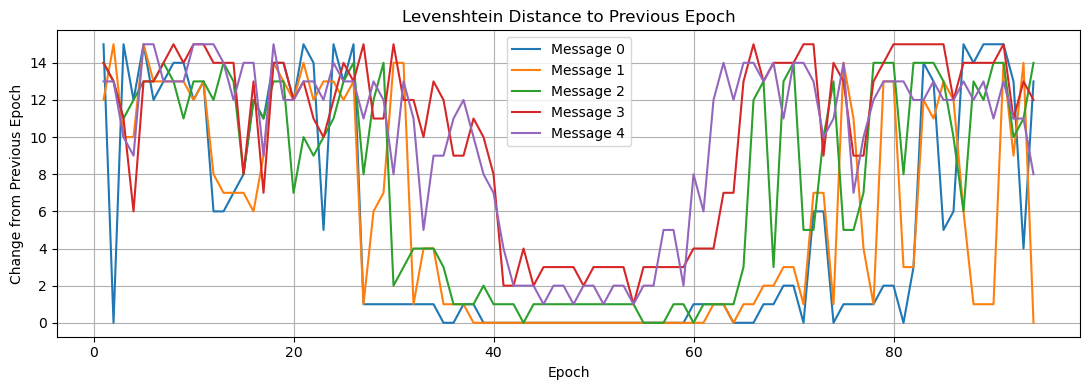

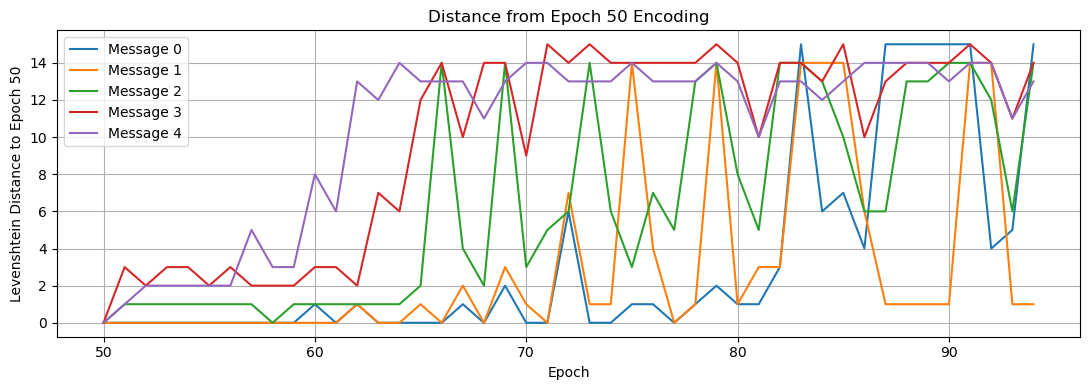

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

def load_message(file_path):
    return np.load(file_path, allow_pickle=True)

def levenshtein(a, b):
    """Compute Levenshtein distance between two lists."""
    dp = np.zeros((len(a)+1, len(b)+1), dtype=int)
    for i in range(len(a)+1):
        dp[i][0] = i
    for j in range(len(b)+1):
        dp[0][j] = j
    for i in range(1, len(a)+1):
        for j in range(1, len(b)+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,     # deletion
                           dp[i][j-1] + 1,     # insertion
                           dp[i-1][j-1] + cost)  # substitution
    return dp[-1][-1]

# === Load message files and sort ===
message_files = glob.glob("dir_save/messages/messages_epoch_*_n_features_*.npy")

def extract_epoch(f):
    match = re.search(r'messages_epoch_(\d+)_n_features_', f)
    return int(match.group(1)) if match else -1

message_files = sorted(message_files, key=extract_epoch)
epochs = [extract_epoch(f) for f in message_files]

# === Track encodings for first 5 messages ===
tracked_messages = {i: [] for i in range(5)}
for f in message_files:
    messages = load_message(f)
    for i in range(5):
        if i < len(messages):
            tracked_messages[i].append(list(messages[i]))
        else:
            tracked_messages[i].append([])

# === Print evolution of message 0 ===
print("🔍 Encoding evolution for message 0:")
for epoch, enc in zip(epochs, tracked_messages[0]):
    print(f"Epoch {epoch}: {enc}")

# === Metric 1: Change between successive epochs ===
evolution_scores = {i: [] for i in range(5)}
for i in range(5):
    messages = tracked_messages[i]
    for t in range(1, len(messages)):
        dist = levenshtein(messages[t-1], messages[t])
        evolution_scores[i].append(dist)

# === Metric 2: Distance from epoch 50 onward ===
reference_epoch = 50
if reference_epoch not in epochs:
    print(f"⚠️ Epoch {reference_epoch} not found in data.")
    reference_scores = {}
else:
    ref_index = epochs.index(reference_epoch)
    reference_scores = {i: [] for i in range(5)}
    for i in range(5):
        ref_encoding = tracked_messages[i][ref_index]
        for t in range(ref_index, len(epochs)):
            current_encoding = tracked_messages[i][t]
            dist = levenshtein(ref_encoding, current_encoding)
            reference_scores[i].append(dist)

# === Plot 1: Evolution over time (change per epoch) ===
plt.figure(figsize=(11, 4))
for i in range(5):
    plt.plot(epochs[1:], evolution_scores[i], label=f"Message {i}")
plt.title("Levenshtein Distance to Previous Epoch")
plt.xlabel("Epoch")
plt.ylabel("Change from Previous Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Distance from epoch 50 ===
if reference_scores:
    plt.figure(figsize=(11, 4))
    for i in range(5):
        plt.plot(epochs[ref_index:], reference_scores[i], label=f"Message {i}")
    plt.title("Distance from Epoch 50 Encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Levenshtein Distance to Epoch 50")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**6. Dynamic evolution of the training**: (takes a few minutes to run)

In [ ]:
print("Create the images for gif")

accuracy_lazimpa=[]
mean_len_lazimpa=[]
accuracy_normal=[]
mean_len_normal=[]
accuracy_impatient=[]
mean_len_impatient=[]
accuracy_normreg=[]
mean_len_normreg=[]

for i in range(1,n_epochs,10):
  messages_lazimpa=load_message("dir_save/messages/messages_"+str(i)+".npy")

  L_lazimpa=[]

  for m in messages_lazimpa:
    L_lazimpa.append(len(m))
  
  mean_len_lazimpa.append(np.mean(L_lazimpa))
  accuracy_lazimpa.append(np.mean(np.load("dir_save/accuracy/accuracy_"+str(i)+".npy")))

  fig, axs = plt.subplots(1, 3, figsize=(11,4))
  axs[0].plot(L_lazimpa,label="LazImpa",c="tab:blue")
  axs[0].set_ylim((0,max_length+1))
  axs[0].set_xlabel("Input ranked by frequency")
  axs[0].set_ylabel("Message length") 
  axs[0].set_title("Length distribution") 

  axs[1].plot(accuracy_lazimpa,label="LazImpa",c="tab:blue")
  axs[1].set_xlabel("Training episodes")
  axs[1].set_ylabel("Accuracy")
  axs[1].set_title("Accuracy evolution")
  axs[1].set_xlim((0,n_epochs))
  axs[1].set_ylim((0,1))

  axs[2].plot(mean_len_lazimpa,label="LazImpa",c="tab:blue")
  axs[2].set_title("Mean length evolution")
  axs[2].set_xlabel("Training episodes")
  axs[2].set_ylabel("Mean message length")
  axs[2].set_xlim((0,n_epochs))
  axs[2].set_ylim((0,max_length+1))

  fig.tight_layout(pad=2.5)

  fig.suptitle("Episode "+str(i)) 
  plt.savefig("images_dir/test"+str(i)+".png")
  plt.close() 

print("Start creating gif for messages")
img2gif("images_dir","analysis/training_dynamic.gif")

Create the images for gif
Start creating gif for messages


Display it:

Display gif


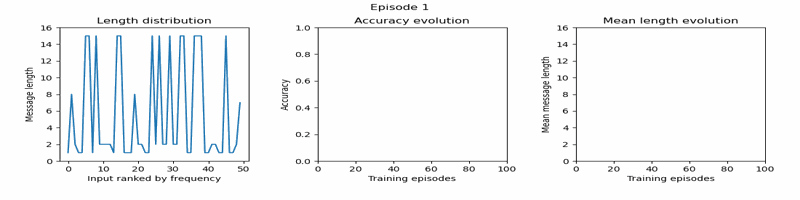

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [ ]:
print("Display gif")
from IPython.display import Image

with open('analysis/training_dynamic.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

! rm -rf images_dir